# Imports

In [1]:
# Add parent directory to path to import gptransform
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
sys.path.insert(0, parent_dir)
import gptransform

# Math libraries
import time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import  MultivariateNormal

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
import string

# Run in float64 to help with numerical stability
# very crucial, remove with caution
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

# Set up the data

Dividing by the average of values greater than r=22.575000000000003


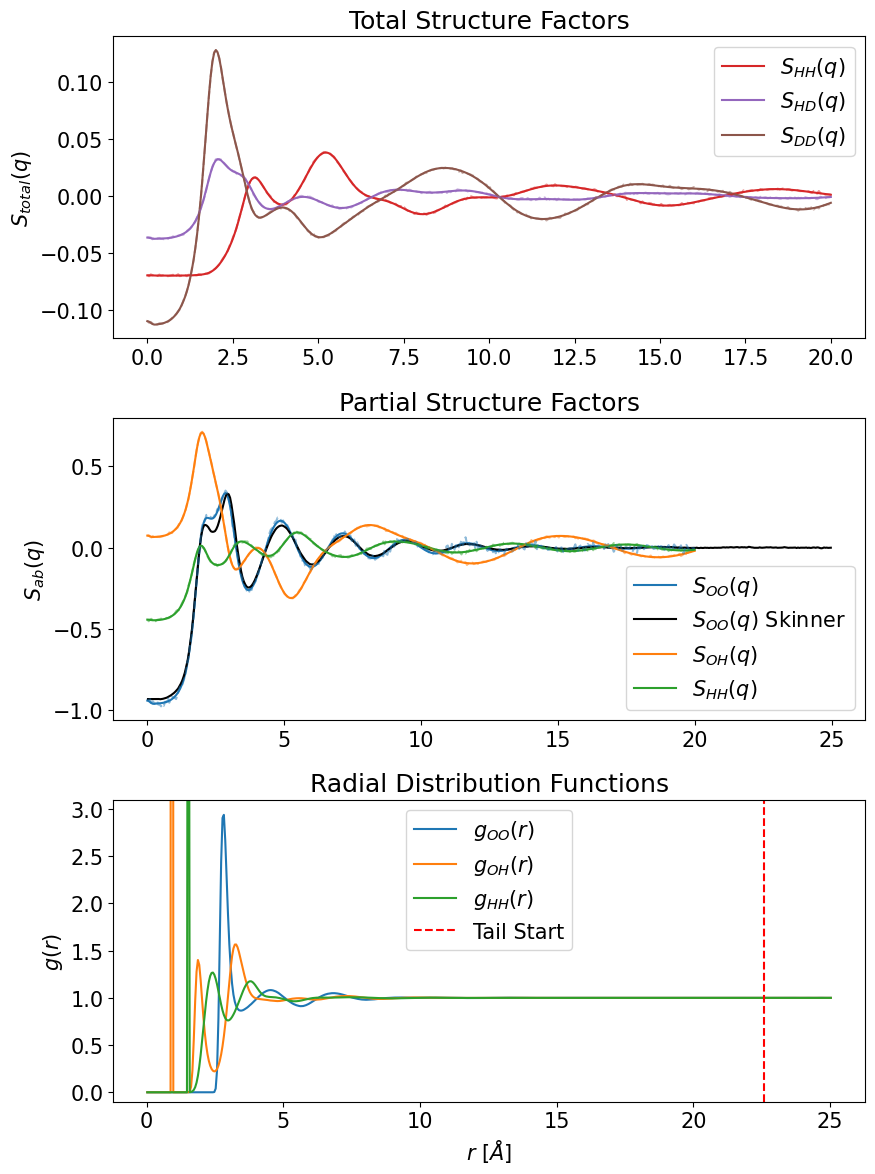

In [2]:
density = 0.0334271795942

import pandas as pd

# Load the data
file_path = 'water_sim_data_matej/Ambient_water_xray_data.txt'
df = pd.read_csv(file_path, sep='\t', skiprows=12, names=[
    'Q', 'I_X(Q)', 'S_OO(Q)', 'r', 'g_OO(r)', 'error'
])

# Convert to PyTorch tensors
Q = torch.tensor(df['Q'].values, dtype=torch.float32)[1:1001:2]
I_X = torch.tensor(df['I_X(Q)'].values, dtype=torch.float32)[1:1001:2]
S_OO_skinner = torch.tensor(df['S_OO(Q)'].values, dtype=torch.float32)[1:1001:2] - 1
r_skinner = torch.tensor(df['r'].values, dtype=torch.float32)[1:]
g_OO_skinner = torch.tensor(df['g_OO(r)'].values, dtype=torch.float32)[1:]
error_skinner = torch.tensor(df['error'].values, dtype=torch.float32)[1:]

# Scattering lengths for water https://www.ncnr.nist.gov/resources/n-lengths/
σOO = 0.0374
σOH = - 0.0964
σHH = 0.0622

σOHD = 0.0378
σHD = 0.0096

σOD = 0.1721 
σDD = 0.1978

M = torch.tensor([[σOO, σOH , σHH],
                  [σOO, σOHD, σHD],
                  [σOO, σOD , σDD]])

M_inv = torch.linalg.inv(M)

# Load in tip4pf data
HH_dat = np.loadtxt("water_sim_data_matej/tip4pf_NPT_HH.dat")
OH_dat = np.loadtxt("water_sim_data_matej/tip4pf_NPT_OH.dat")
OO_dat = np.loadtxt("water_sim_data_matej/tip4pf_NPT_OO.dat")

r_OH,gr_OH = OH_dat.T[0],OH_dat.T[1]
r_OO,gr_OO = OO_dat.T[0],OO_dat.T[1]
r_HH,gr_HH = HH_dat.T[0],HH_dat.T[1]

r_OH = torch.tensor(r_OH)
gr_OH = torch.tensor(gr_OH)
r_HH = torch.tensor(r_HH)
gr_HH = torch.tensor(gr_HH)
r_OO = torch.tensor(r_OO)
gr_OO = torch.tensor(gr_OO)


average_tail_count = 50
print(f'Dividing by the average of values greater than r={r_OH[-average_tail_count]}')
gr_OH =  gr_OH / torch.mean(gr_OH[-average_tail_count:])
gr_OO =  gr_OO / torch.mean(gr_OO[-average_tail_count:])
gr_HH =  gr_HH / torch.mean(gr_HH[-average_tail_count:])


# Store as matrix for easy dot product application to obtain total G(r)
structure_partial = torch.zeros((3,len(gr_OO)))
structure_partial[0] = gr_OO - 1
structure_partial[1] = gr_OH - 1
structure_partial[2] = gr_HH - 1
structure_total = (M @ structure_partial)


# Establish a q space grid and compute total S(q) structure factors
q = torch.linspace(0.001, 20, 400)
sq_HH = gptransform.rdf2sq(r_OO, structure_total[0], q, density)
sq_HD = gptransform.rdf2sq(r_OO, structure_total[1], q, density)
sq_DD = gptransform.rdf2sq(r_OO, structure_total[2], q, density)

# Get noisless partial S(q)
partial_sq_OO = gptransform.rdf2sq(r_OO, gr_OO-1, q, density)
partial_sq_OH = gptransform.rdf2sq(r_OH, gr_OH-1, q, density)
partial_sq_HH = gptransform.rdf2sq(r_HH, gr_HH-1, q, density)

# Sample some random noise to simulate experimental error
noise_HH = torch.normal(torch.zeros_like(q), torch.ones_like(q)*0.0005)
noise_HD = torch.normal(torch.zeros_like(q), torch.ones_like(q)*0.0005)
noise_DD = torch.normal(torch.zeros_like(q), torch.ones_like(q)*0.0005)

# Convert all these things to column vectors for consistency
r = r_OO

r_grid = torch.linspace(0.01, 25  , 1000).reshape(-1,1)
q_values = q.reshape(-1,1)
sq_HH = sq_HH.reshape(-1,1)
sq_HD = sq_HD.reshape(-1,1)
sq_DD = sq_DD.reshape(-1,1)

partial_sq_OO = partial_sq_OO.reshape(-1,1)
partial_sq_OH = partial_sq_OH.reshape(-1,1)
partial_sq_HH = partial_sq_HH.reshape(-1,1)

noise_HH = noise_HH.reshape(-1,1)
noise_HD = noise_HD.reshape(-1,1)
noise_DD = noise_DD.reshape(-1,1)

# We observe the total structure in experimental data, therefore the noise should be added here.
# Constant noise on the total as a function of deuteration doesnt imply constant over partials
# This is why some partials will be harder to learn, we reflect that here in the toy problem.
sq_noisey_HH = (sq_HH+noise_HH)
sq_noisey_HD = (sq_HD+noise_HD)
sq_noisey_DD = (sq_DD+noise_DD)

# Save total noisey and compute partials via matrix inverse
structure_total_q_noisey = torch.zeros((3,len(q)))
structure_total_q_noisey[0] = sq_noisey_HH.T[0]
structure_total_q_noisey[1] = sq_noisey_HD.T[0]
structure_total_q_noisey[2] = sq_noisey_DD.T[0]
structure_partial_q_noisey = M_inv @ structure_total_q_noisey

# Sometimes I will want to refer to them without the matrix
partial_sq_noisey_OO = structure_partial_q_noisey[0].reshape(-1,1)
partial_sq_noisey_OH = structure_partial_q_noisey[1].reshape(-1,1)
partial_sq_noisey_HH = structure_partial_q_noisey[2].reshape(-1,1)
    
# This allows you to mix up the data so its not ordered by q
perm = torch.randperm(len(structure_total_q_noisey[0]))

# Put into Pytorch Dataloader
# Change the reshape command to get different batch sizes, not needed here as there is not enough observations
# so we can do full gradient descent on the LMLH. 
dataset_OO = gptransform.data(q_values[perm].reshape(1,400,1),structure_partial_q_noisey[0][perm].reshape(1,400,1))
dataset_OH = gptransform.data(q_values[perm].reshape(1,400,1),structure_partial_q_noisey[1][perm].reshape(1,400,1))
dataset_HH = gptransform.data(q_values[perm].reshape(1,400,1),structure_partial_q_noisey[2][perm].reshape(1,400,1))
fig, axs = plt.subplots(3, 1, figsize=(9, 12), sharex=False)

# Plot all the functions for visualization
color_OO = 'tab:blue'
color_OH = 'tab:orange'
color_HH = 'tab:green'
color_HH_tot = 'tab:red'
color_HD_tot = 'tab:purple'
color_DD_tot = 'tab:brown'

axs[0].plot(q_values, sq_HH, label="$S_{HH}(q)$", color=color_HH_tot)
axs[0].plot(q_values, sq_HD, label="$S_{HD}(q)$", color=color_HD_tot)
axs[0].plot(q_values, sq_DD, label="$S_{DD}(q)$", color=color_DD_tot)
axs[0].plot(q_values, sq_noisey_HH, linestyle='dashed', alpha=0.5, color=color_HH_tot)
axs[0].plot(q_values, sq_noisey_HD, linestyle='dashed', alpha=0.5, color=color_HD_tot)
axs[0].plot(q_values, sq_noisey_DD, linestyle='dashed', alpha=0.5, color=color_DD_tot)
axs[0].set_ylabel("$S_{total}(q)$")
axs[0].set_title("Total Structure Factors")
axs[0].legend()

axs[1].plot(q_values, partial_sq_OO, label="$S_{OO}(q)$", color=color_OO)
axs[1].plot(Q, S_OO_skinner, label="$S_{OO}(q)$ Skinner", color='k')
axs[1].plot(q_values, partial_sq_OH, label="$S_{OH}(q)$", color=color_OH)
axs[1].plot(q_values, partial_sq_HH, label="$S_{HH}(q)$", color=color_HH)
axs[1].plot(q_values, partial_sq_noisey_OO, linestyle='dashed', alpha=0.5, color=color_OO)
axs[1].plot(q_values, partial_sq_noisey_OH, linestyle='dashed', alpha=0.5, color=color_OH)
axs[1].plot(q_values, partial_sq_noisey_HH, linestyle='dashed', alpha=0.5, color=color_HH)
axs[1].set_ylabel("$S_{ab}(q)$")
axs[1].set_title("Partial Structure Factors")
axs[1].legend()

axs[2].plot(r_OO, gr_OO, label="$g_{OO}(r)$", color=color_OO)
axs[2].plot(r_OH, gr_OH, label="$g_{OH}(r)$", color=color_OH)
axs[2].plot(r_HH, gr_HH, label="$g_{HH}(r)$", color=color_HH)
axs[2].axvline(r_OH[-average_tail_count], linestyle='dashed', color='r', label='Tail Start')
axs[2].set_ylim(-0.1, 3.1)
axs[2].set_xlabel("$r\ [\AA]$")
axs[2].set_ylabel("$g(r)$")
axs[2].set_title("Radial Distribution Functions")
axs[2].legend()

plt.tight_layout()
plt.show()

# Just save these for later
q_infer = q_values
r_infer = r_grid
temp = 298.15

# Run the optimization

Average loss: -124.405465  [    0/  500]
l:       1.288000 
max:     2.081001 
slope:   2.020554 
loc:     1.495000 
decay:   0.529750 
sigma_n: 0.247551 
r_0:     1.495000 
s:       5.075895 
h:   2.574499 
r:   0.943778 
s:   0.015155 
Minutes Taken Since Last Report: 0.082812 



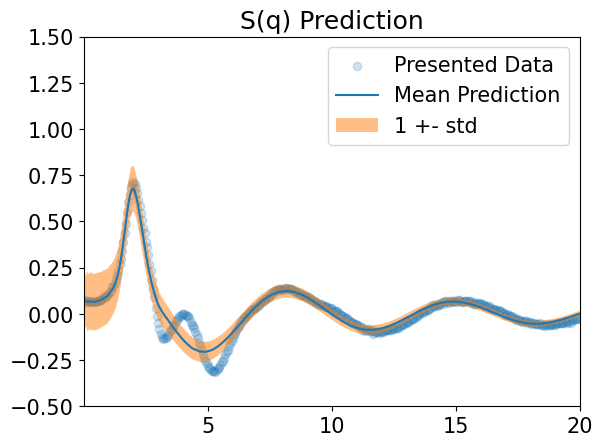

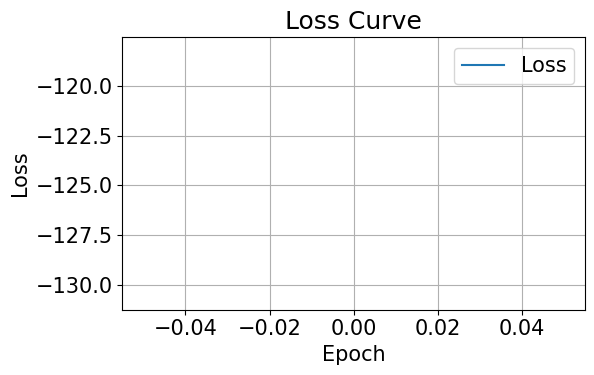

Average loss: -223.746383  [   25/  500]
l:       0.973058 
max:     1.618371 
slope:   2.687045 
loc:     1.429900 
decay:   0.641592 
sigma_n: 0.185573 
r_0:     1.416102 
s:       7.498970 
h:   2.758950 
r:   0.919552 
s:   0.014681 
Minutes Taken Since Last Report: 2.082344 



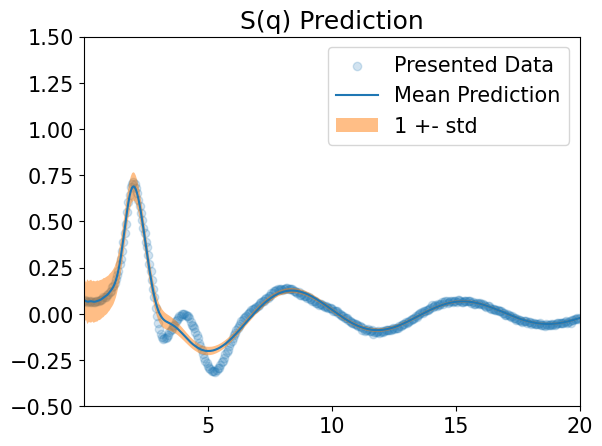

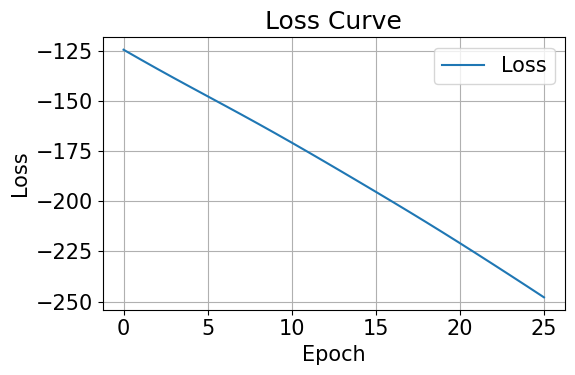

Average loss: -372.618004  [   50/  500]
l:       0.637291 
max:     1.271844 
slope:   3.729967 
loc:     1.552113 
decay:   0.726572 
sigma_n: 0.127945 
r_0:     1.558269 
s:       10.785169 
h:   2.855076 
r:   0.923358 
s:   0.014539 
Minutes Taken Since Last Report: 1.948113 



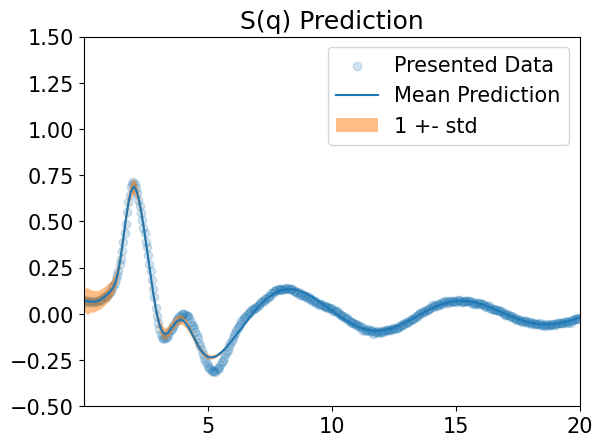

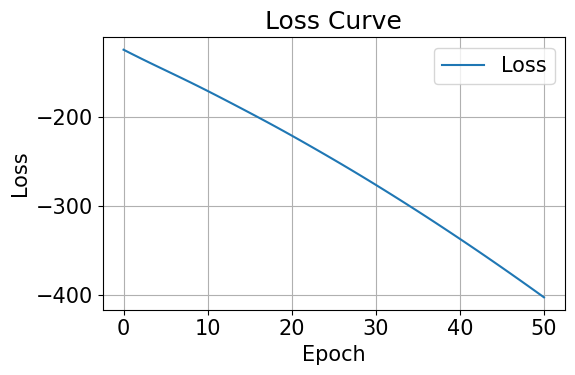

Average loss: -549.919792  [   75/  500]
l:       0.424623 
max:     1.067323 
slope:   5.580770 
loc:     1.680708 
decay:   0.787945 
sigma_n: 0.081119 
r_0:     1.693523 
s:       14.706534 
h:   2.859463 
r:   0.924060 
s:   0.014556 
Minutes Taken Since Last Report: 2.084946 



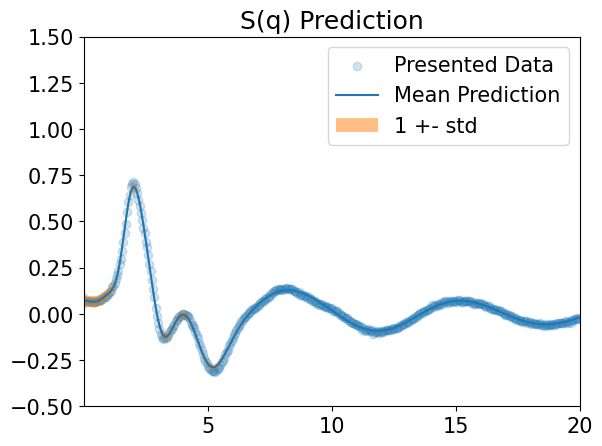

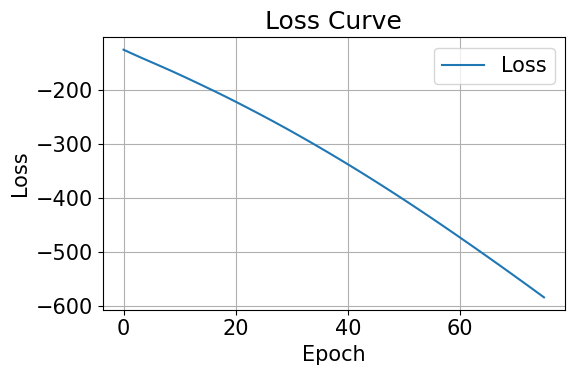

Average loss: -744.450924  [  100/  500]
l:       0.367399 
max:     0.897479 
slope:   8.552098 
loc:     1.776545 
decay:   0.828144 
sigma_n: 0.048637 
r_0:     1.721936 
s:       18.983893 
h:   2.858511 
r:   0.923595 
s:   0.013797 
Minutes Taken Since Last Report: 1.868223 



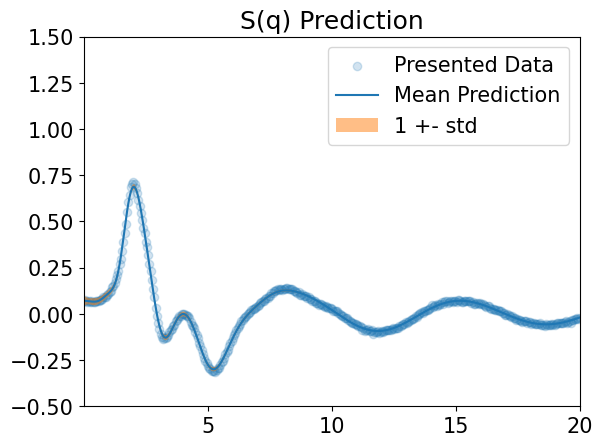

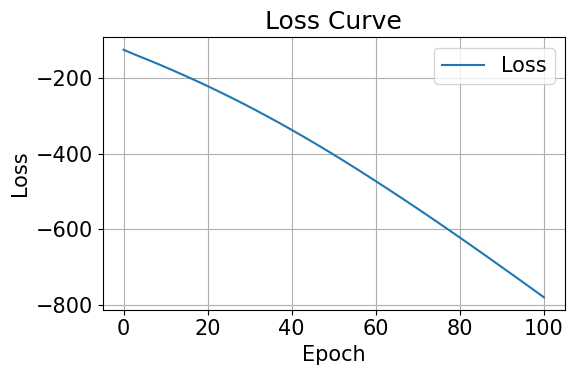

Average loss: -945.752517  [  125/  500]
l:       0.362572 
max:     0.923557 
slope:   12.901846 
loc:     1.850266 
decay:   0.841004 
sigma_n: 0.028492 
r_0:     1.728064 
s:       23.315713 
h:   2.869888 
r:   0.925047 
s:   0.013695 
Minutes Taken Since Last Report: 2.059829 



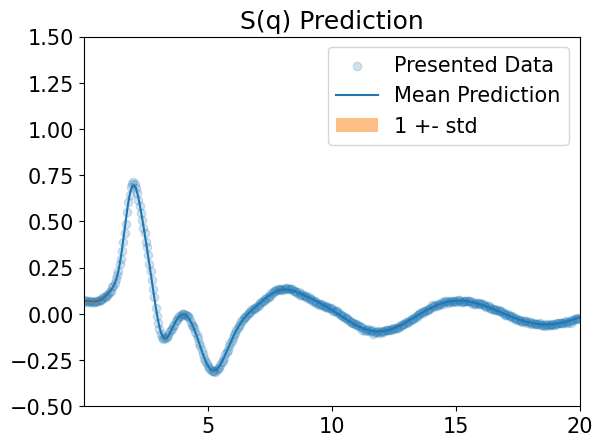

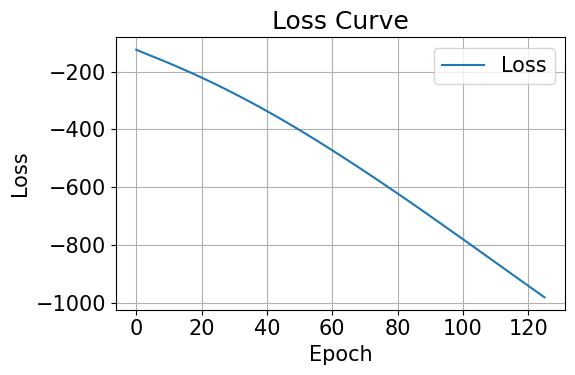

Average loss: -1143.249025  [  150/  500]
l:       0.376468 
max:     1.097617 
slope:   17.816690 
loc:     1.837910 
decay:   0.824695 
sigma_n: 0.016691 
r_0:     1.734867 
s:       26.537003 
h:   2.874917 
r:   0.925034 
s:   0.013464 
Minutes Taken Since Last Report: 1.955918 



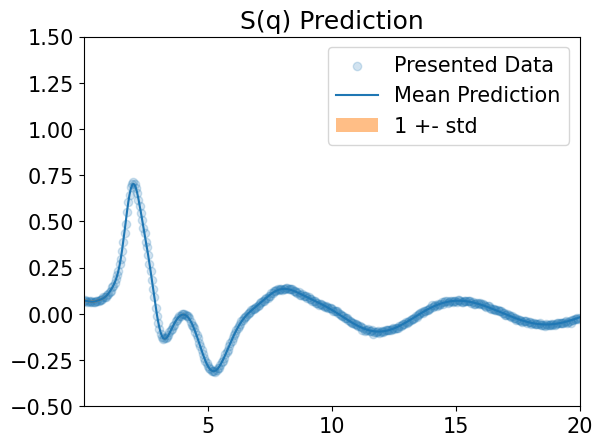

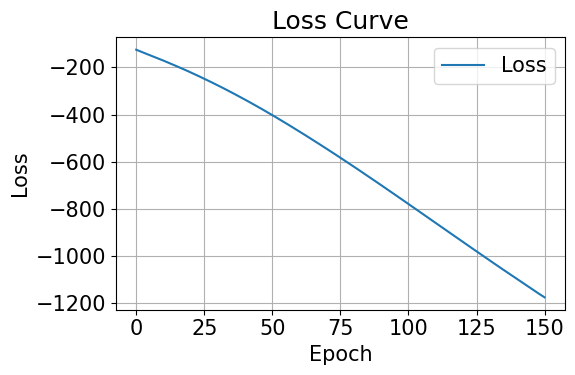

Average loss: -1324.152756  [  175/  500]
l:       0.383664 
max:     1.152616 
slope:   21.748258 
loc:     1.849772 
decay:   0.798439 
sigma_n: 0.009996 
r_0:     1.728086 
s:       27.492802 
h:   2.874201 
r:   0.924729 
s:   0.013368 
Minutes Taken Since Last Report: 1.872109 



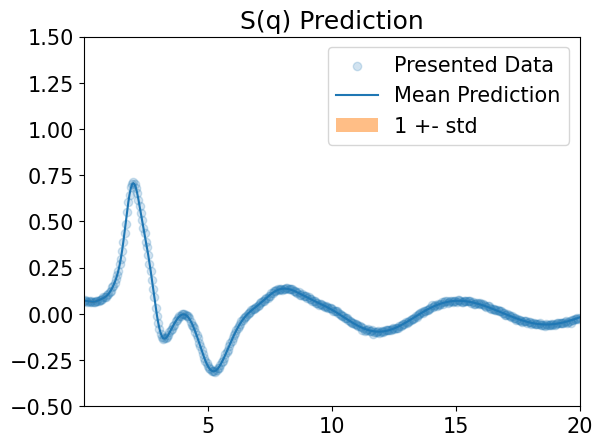

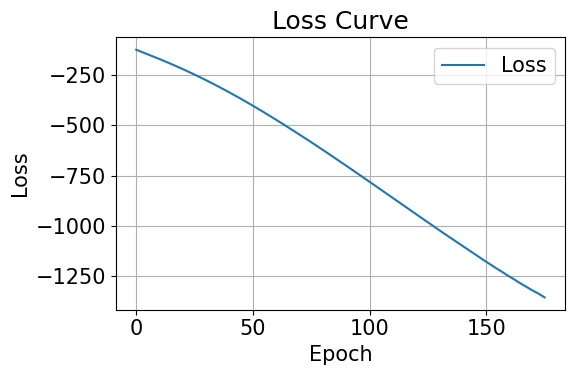

Average loss: -1465.594158  [  200/  500]
l:       0.369619 
max:     1.082476 
slope:   24.388350 
loc:     1.855393 
decay:   0.783329 
sigma_n: 0.006363 
r_0:     1.723872 
s:       27.407544 
h:   2.871042 
r:   0.923322 
s:   0.013276 
Minutes Taken Since Last Report: 2.028600 



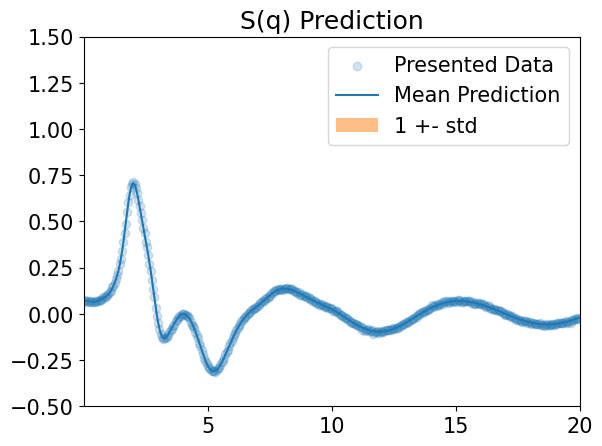

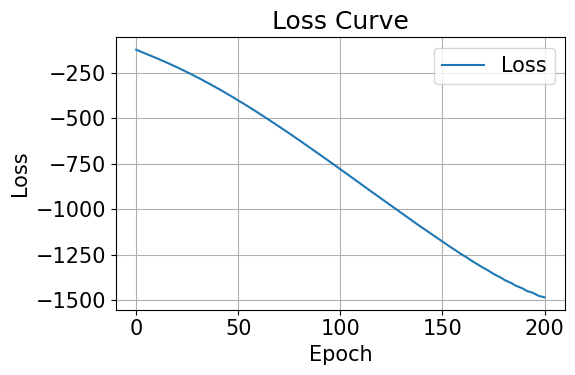

Average loss: -1541.667070  [  225/  500]
l:       0.359136 
max:     1.015905 
slope:   25.887099 
loc:     1.851582 
decay:   0.765090 
sigma_n: 0.004586 
r_0:     1.721740 
s:       27.580641 
h:   2.877695 
r:   0.924617 
s:   0.013183 
Minutes Taken Since Last Report: 2.141523 



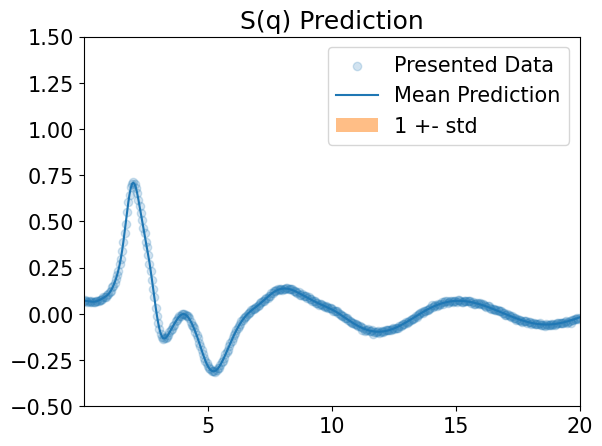

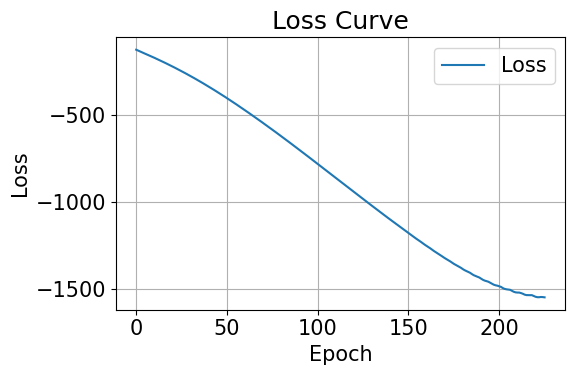

Average loss: -1564.028909  [  250/  500]
l:       0.350076 
max:     0.931029 
slope:   26.870686 
loc:     1.849351 
decay:   0.743106 
sigma_n: 0.003913 
r_0:     1.721788 
s:       27.757966 
h:   2.879499 
r:   0.923675 
s:   0.012906 
Minutes Taken Since Last Report: 2.072294 



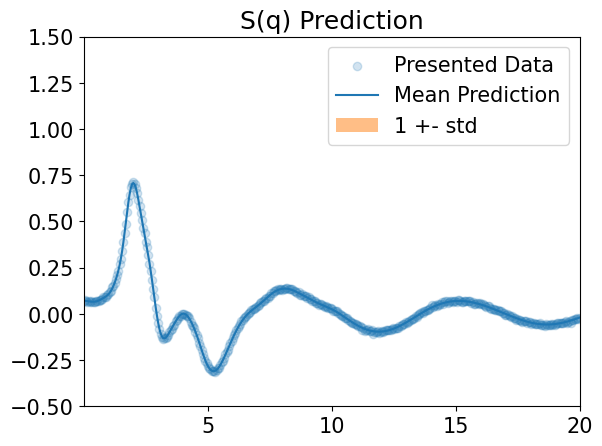

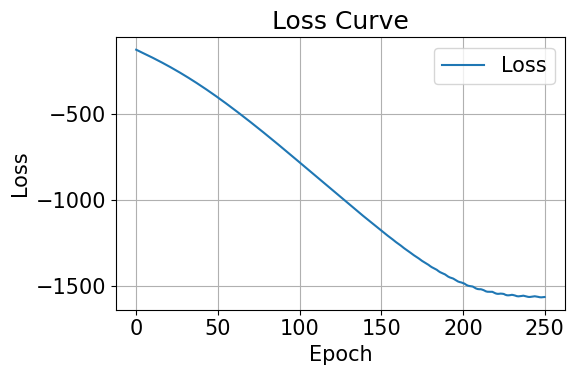

Average loss: -1567.021781  [  275/  500]
l:       0.343996 
max:     0.865880 
slope:   27.719243 
loc:     1.847221 
decay:   0.728903 
sigma_n: 0.003768 
r_0:     1.721106 
s:       27.768939 
h:   2.888810 
r:   0.924045 
s:   0.012610 
Minutes Taken Since Last Report: 2.121335 



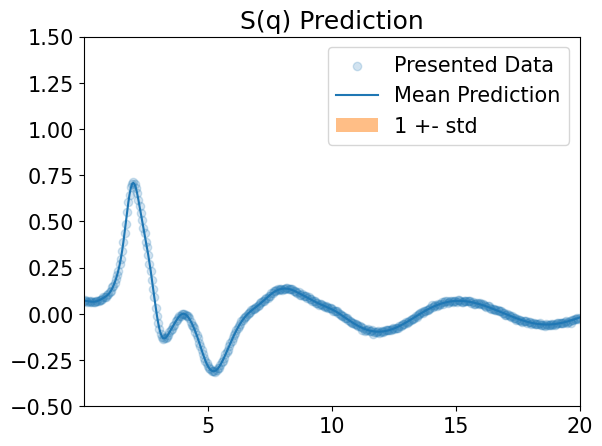

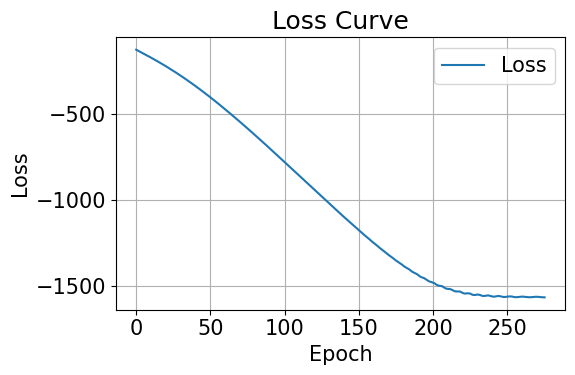

Average loss: -1567.608549  [  300/  500]
l:       0.342642 
max:     0.851001 
slope:   28.454374 
loc:     1.846322 
decay:   0.725987 
sigma_n: 0.003765 
r_0:     1.720575 
s:       27.770912 
h:   2.897811 
r:   0.924308 
s:   0.012376 
Minutes Taken Since Last Report: 1.742716 



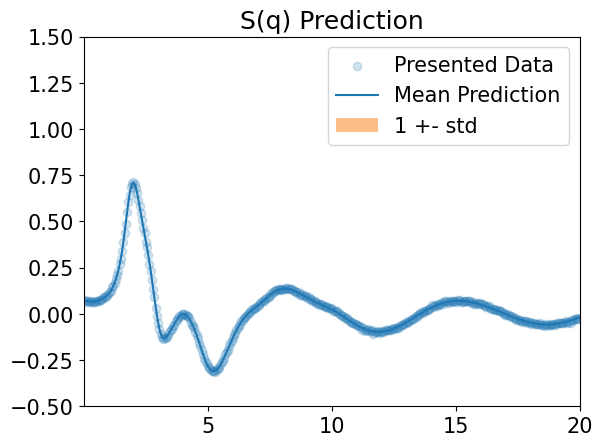

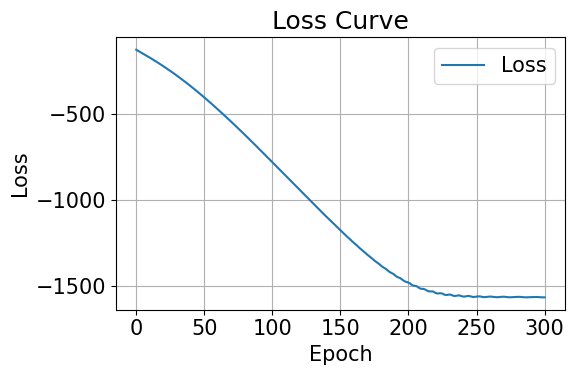

Average loss: -1567.620444  [  325/  500]
l:       0.342831 
max:     0.854201 
slope:   28.985924 
loc:     1.846041 
decay:   0.726612 
sigma_n: 0.003768 
r_0:     1.720139 
s:       27.819630 
h:   2.903442 
r:   0.924260 
s:   0.012218 
Minutes Taken Since Last Report: 1.819880 



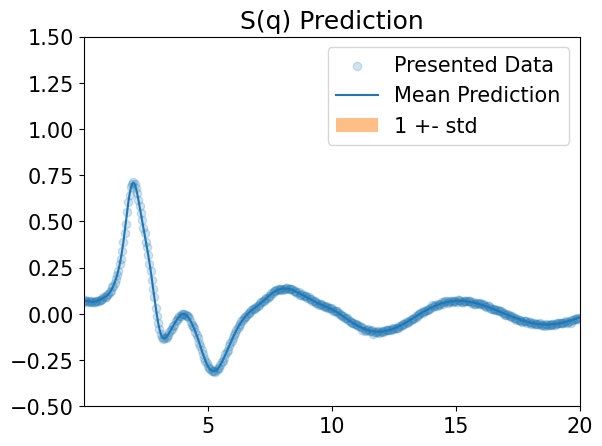

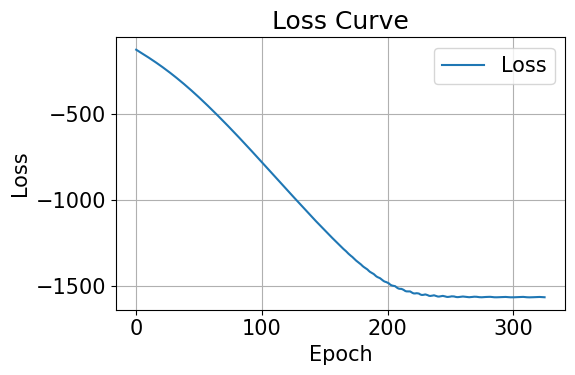

Average loss: -1568.303556  [  350/  500]
l:       0.342998 
max:     0.854043 
slope:   29.331259 
loc:     1.845806 
decay:   0.726710 
sigma_n: 0.003766 
r_0:     1.719880 
s:       27.888880 
h:   2.906570 
r:   0.924134 
s:   0.012124 
Minutes Taken Since Last Report: 2.025721 



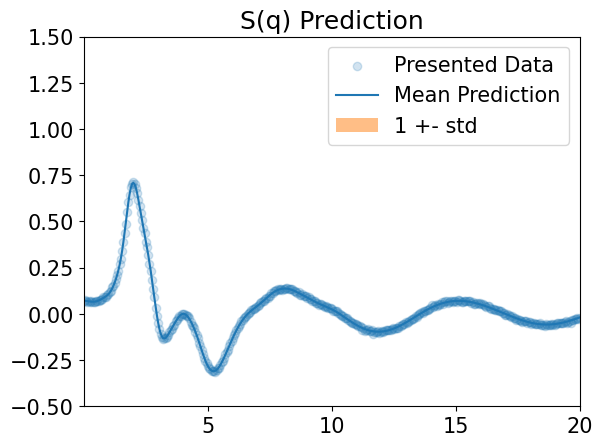

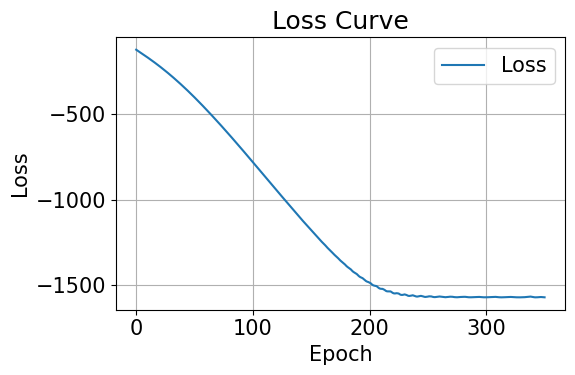

Average loss: -1566.921405  [  375/  500]
l:       0.342545 
max:     0.853672 
slope:   29.606279 
loc:     1.845468 
decay:   0.726276 
sigma_n: 0.003756 
r_0:     1.719223 
s:       27.952566 
h:   2.913590 
r:   0.924526 
s:   0.012035 
Minutes Taken Since Last Report: 1.932458 



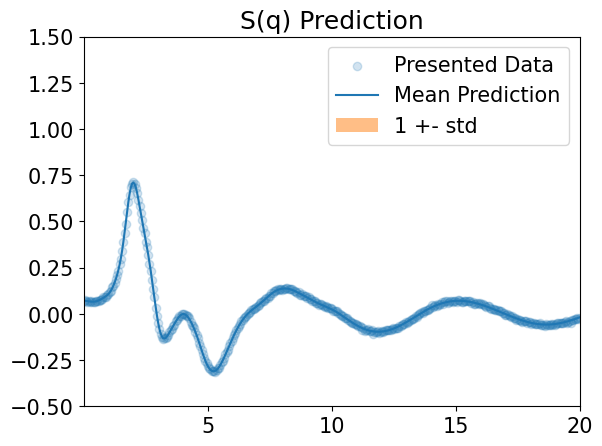

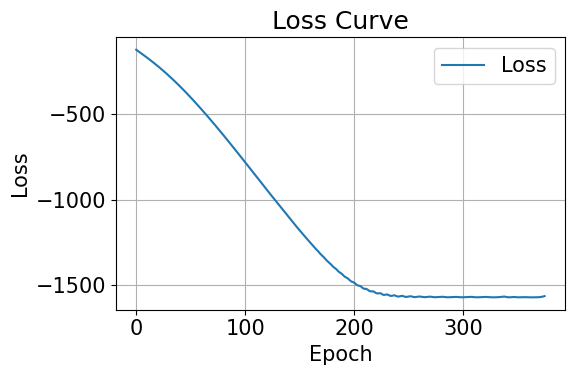

Average loss: -1568.753998  [  400/  500]
l:       0.342775 
max:     0.852067 
slope:   29.740930 
loc:     1.846322 
decay:   0.726231 
sigma_n: 0.003759 
r_0:     1.719676 
s:       27.975873 
h:   2.910954 
r:   0.923928 
s:   0.012008 
Minutes Taken Since Last Report: 1.921844 



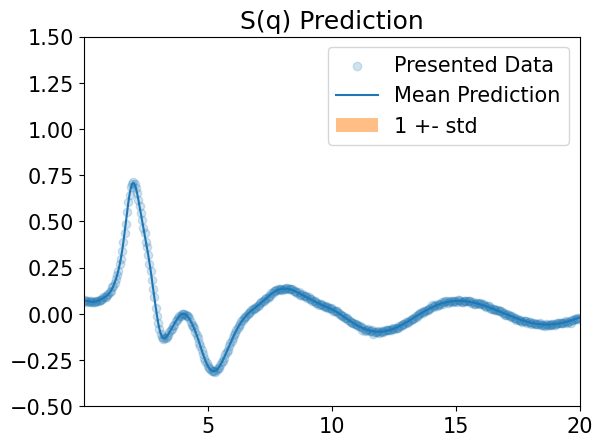

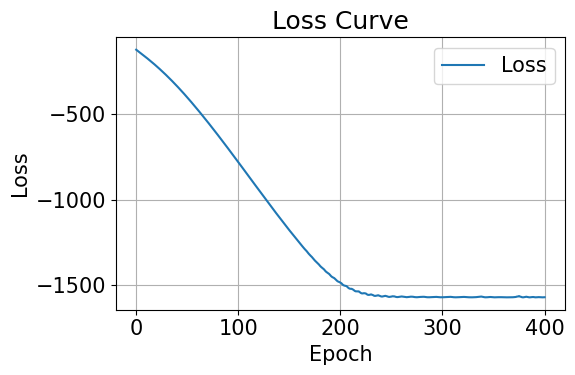

Average loss: -1568.675895  [  425/  500]
l:       0.342526 
max:     0.851946 
slope:   29.933251 
loc:     1.845978 
decay:   0.725923 
sigma_n: 0.003746 
r_0:     1.719199 
s:       28.040491 
h:   2.917592 
r:   0.924389 
s:   0.011920 
Minutes Taken Since Last Report: 1.768188 



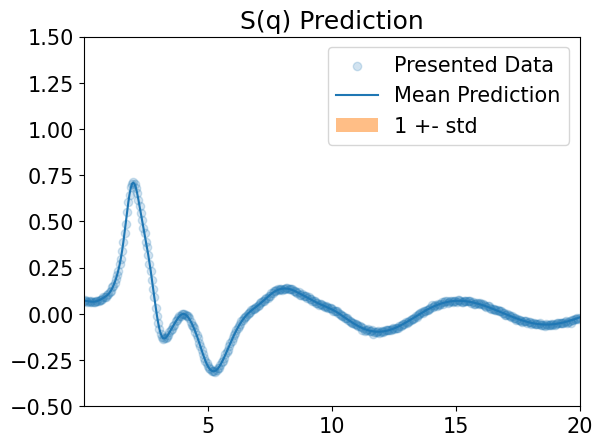

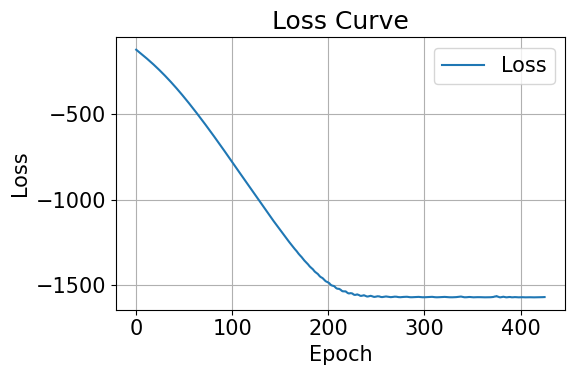

Average loss: -1568.481841  [  450/  500]
l:       0.342398 
max:     0.850600 
slope:   30.024646 
loc:     1.846100 
decay:   0.725725 
sigma_n: 0.003749 
r_0:     1.719302 
s:       28.066665 
h:   2.918750 
r:   0.924222 
s:   0.011876 
Minutes Taken Since Last Report: 1.620292 



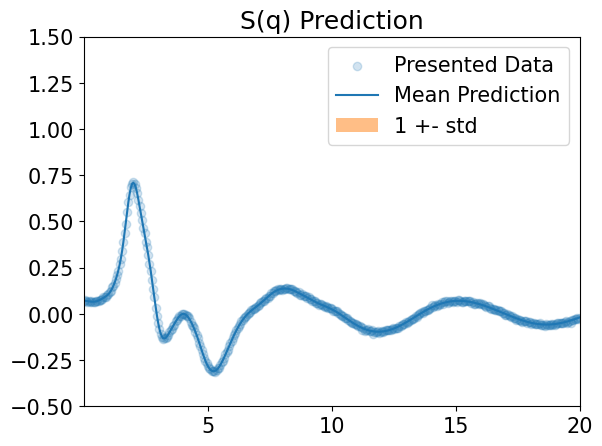

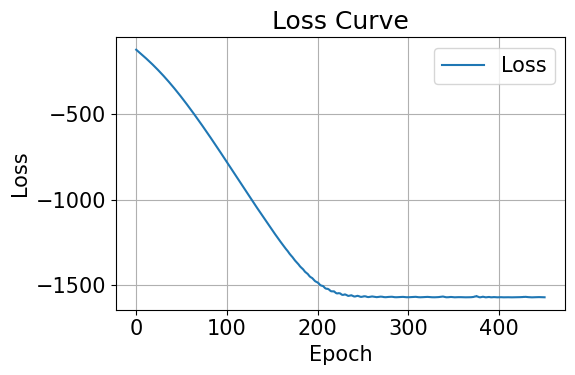

Average loss: -1564.953756  [  475/  500]
l:       0.341784 
max:     0.851755 
slope:   30.077970 
loc:     1.845021 
decay:   0.725661 
sigma_n: 0.003749 
r_0:     1.719071 
s:       28.107310 
h:   2.920112 
r:   0.924007 
s:   0.011820 
Minutes Taken Since Last Report: 1.456830 



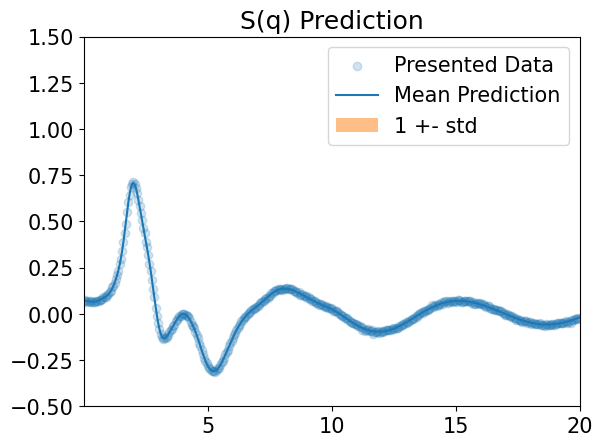

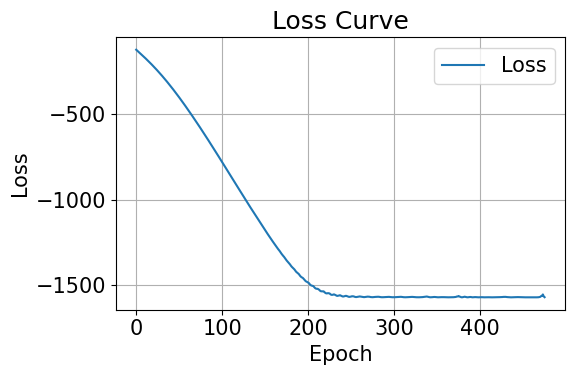

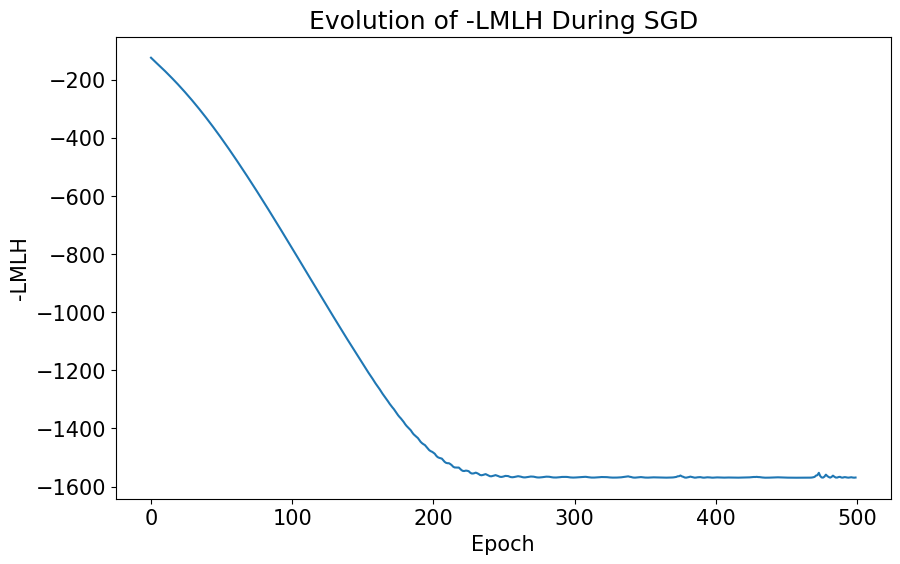

In [3]:
psq_name = 'OH'

init_param_bounds = torch.zeros((11,2))

### Width Function Params ###

# Ell
init_param_bounds[0,1] = 2.5
init_param_bounds[0,0] = 0.1


# Max
init_param_bounds[1,1] = 4
init_param_bounds[1,0] = 0.2

# Slope
init_param_bounds[2,1] = 50
init_param_bounds[2,0] = 1

# Loc
init_param_bounds[3,1] = 2
init_param_bounds[3,0] = 1

# Decay
init_param_bounds[4,1] = 1
init_param_bounds[4,0] = 0.05

### Experimental Noise ###

# Sigma_n
init_param_bounds[5,1] = 0.5
init_param_bounds[5,0] = 0.0001

### Non-Bonded Peaks in Mean ###

# r_0
init_param_bounds[6,1] = 2
init_param_bounds[6,0] = 1

# s
init_param_bounds[7,1] = 50
init_param_bounds[7,0] = 1

### Bonded Peaks in Mean ### 

# h_1
init_param_bounds[8,1] = 5
init_param_bounds[8,0] = 0.1

# r_1
init_param_bounds[9,1] = 2
init_param_bounds[9,0] = 0.5

# s_1
init_param_bounds[10,1] = 0.03
init_param_bounds[10,0] = 0.00001

# Create initial parameters
init_params = torch.sum(init_param_bounds,dim=1)/2

init_params[9] = 0.95
init_params[2] = 2
init_params[7] = 5

model_path = 'models/'+str(temp)+'_'+psq_name+'_GP'
loss_path = 'models/'+str(temp)+'_'+psq_name+'_losses.pt'

# Create GP Object
gp = gptransform.GP(init_params, init_param_bounds, 1, density, temp)

# Perform hyper parameter optimization
optimizer = torch.optim.AdamW(gp.parameters(), lr=2e-2)
losses = gptransform.train_loop(dataset_OH, gp, optimizer, 500, r_grid, q_values,  partial_sq_noisey_OH, q_infer, r_infer, -0.5,1.5, -0.1,3.1)

# Save GP
torch.save(gp, model_path)
torch.save(torch.tensor(losses), loss_path)

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(losses, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('-LMLH')
plt.title('Evolution of -LMLH During SGD')
plt.savefig('figs/'+str(temp)+'_'+psq_name+'_LMLH.png')
plt.show()

# Resulting Hyper Parameters

In [18]:
names = ["l", "max", "slope", "loc", "decay", "sigma_n", "r_0", "s", "h","r","s"]

print(f"{'Name':<10} {'Init Value':<12} {'Lower Bound':<15} {'Upper Bound':<15} {'Final Value':<15} {'Δ':<12} {'% Change':<10}")
print("-" * 100)

for name, init, lo, hi, final in zip(
    names,
    init_params.tolist(),
    init_param_bounds.T[0].tolist(),
    init_param_bounds.T[1].tolist(),
    gp.theta.tolist()
):
    delta = final - init
    denom = hi - lo
    percent = 100 * delta / denom 
    print(f"{name:<10} {init:<12.6f} {lo:<15.6f} {hi:<15.6f} {final:<15.6f} {delta:<12.6f} {percent:<10.2f}")


Name       Init Value   Lower Bound     Upper Bound     Final Value     Δ            % Change  
----------------------------------------------------------------------------------------------------
l          1.300000     0.100000        2.500000        0.342870        -0.957130    -39.88    
max        2.100000     0.200000        4.000000        0.851435        -1.248565    -32.86    
slope      2.000000     1.000000        50.000000       29.911977       27.911977    56.96     
loc        1.500000     1.000000        2.000000        1.846118        0.346118     34.61     
decay      0.525000     0.050000        1.000000        0.726299        0.201299     21.19     
sigma_n    0.250050     0.000100        0.500000        0.003765        -0.246285    -49.27    
r_0        1.500000     1.000000        2.000000        1.719218        0.219218     21.92     
s          5.000000     1.000000        50.000000       27.972930       22.972930    46.88     
h          2.550000     0.100000   

# Apply Laplaces Approximation

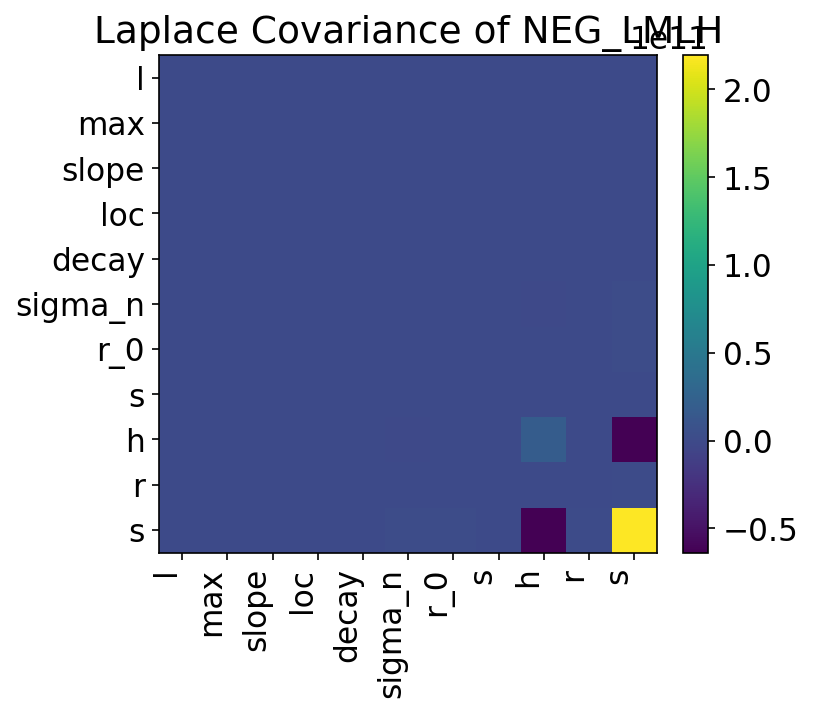

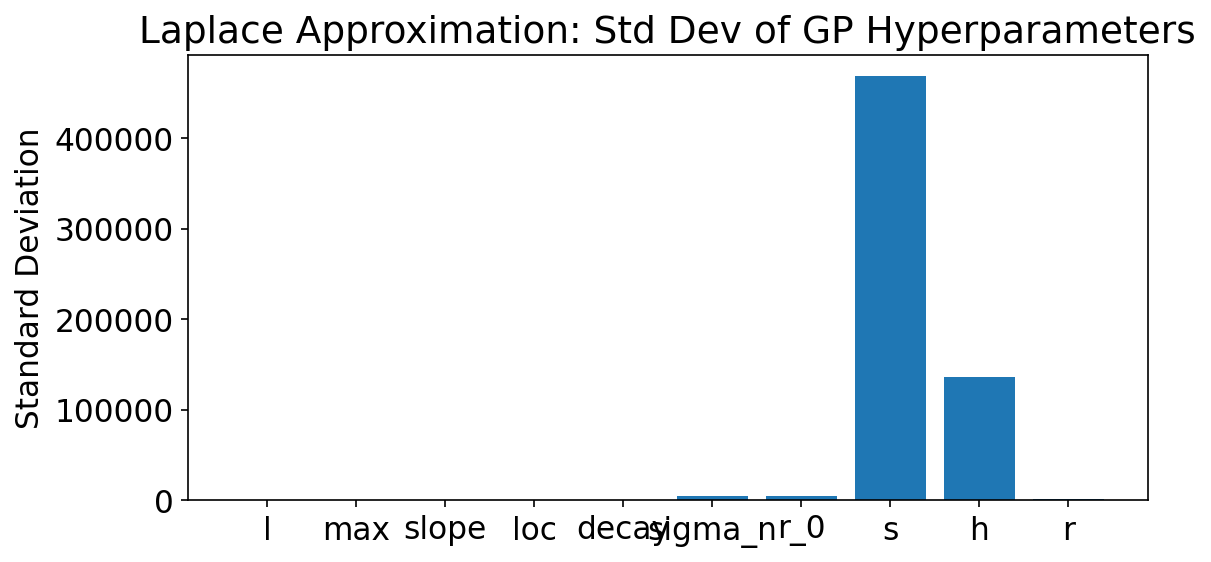

In [5]:
q_train = q_values
sq_train = partial_sq_noisey_OH

loss_at_map = gp.NEG_LMLH_Trapz(r_grid, q_values, sq_train)

grad = torch.autograd.grad(loss_at_map, gp.theta_raw, create_graph=True)[0]  # shape: (P,)
P = grad.numel()
grad_flat = grad.view(-1)

H = torch.zeros(P, P, device=grad.device)
for i in range(P):
    grad2 = torch.autograd.grad(grad_flat[i], gp.theta_raw, retain_graph=True)[0].view(-1)
    H[i] = grad2.detach()

L = torch.linalg.cholesky(gp.nearestPD(H))  
cov_laplace = torch.cholesky_inverse(L)

stds = torch.sqrt(torch.diag(cov_laplace)).cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
im = ax.imshow(cov_laplace, cmap='viridis')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(range(P))
ax.set_yticks(range(P))
ax.set_xticklabels(names, rotation=90, ha='right')
ax.set_yticklabels(names)
ax.set_title("Laplace Covariance of NEG_LMLH")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
ax.bar(names, stds)
ax.set_ylabel("Standard Deviation")
ax.set_title("Laplace Approximation: Std Dev of GP Hyperparameters")
plt.tight_layout()
plt.show()

#  Compute the Posteriors

In [16]:
with torch.no_grad():

    r_grid =  torch.linspace(0.01, 25  , 1000).reshape(-1,1)
    r_infer = torch.linspace(0.01, 12.5, 1000).reshape(-1,1)
    q_infer = torch.linspace(0.01, 12.5, 1000).reshape(-1,1)

    # Calculate Posterior Mean and Cov in momentum space
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()
    
    μ_q_prior = gp.mean_q(r_grid,q_infer)
    Σ_q_prior = gp.K_qq(r_grid, r_grid, q_infer, q_infer,adjust=False)

    # Calculate Posterior Mean and Cov in real space
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer, q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()
    
    μ_r_prior = gp.mean_r(r_infer)
    Σ_r_prior = gp.K_rr(r_infer, r_infer,adjust=False)

    kernels = [(Σ_q_post, q_infer.T[0], q_infer.T[0]),(Σ_r_post, r_infer.T[0], r_infer.T[0])]   

# Plot the Posteriors

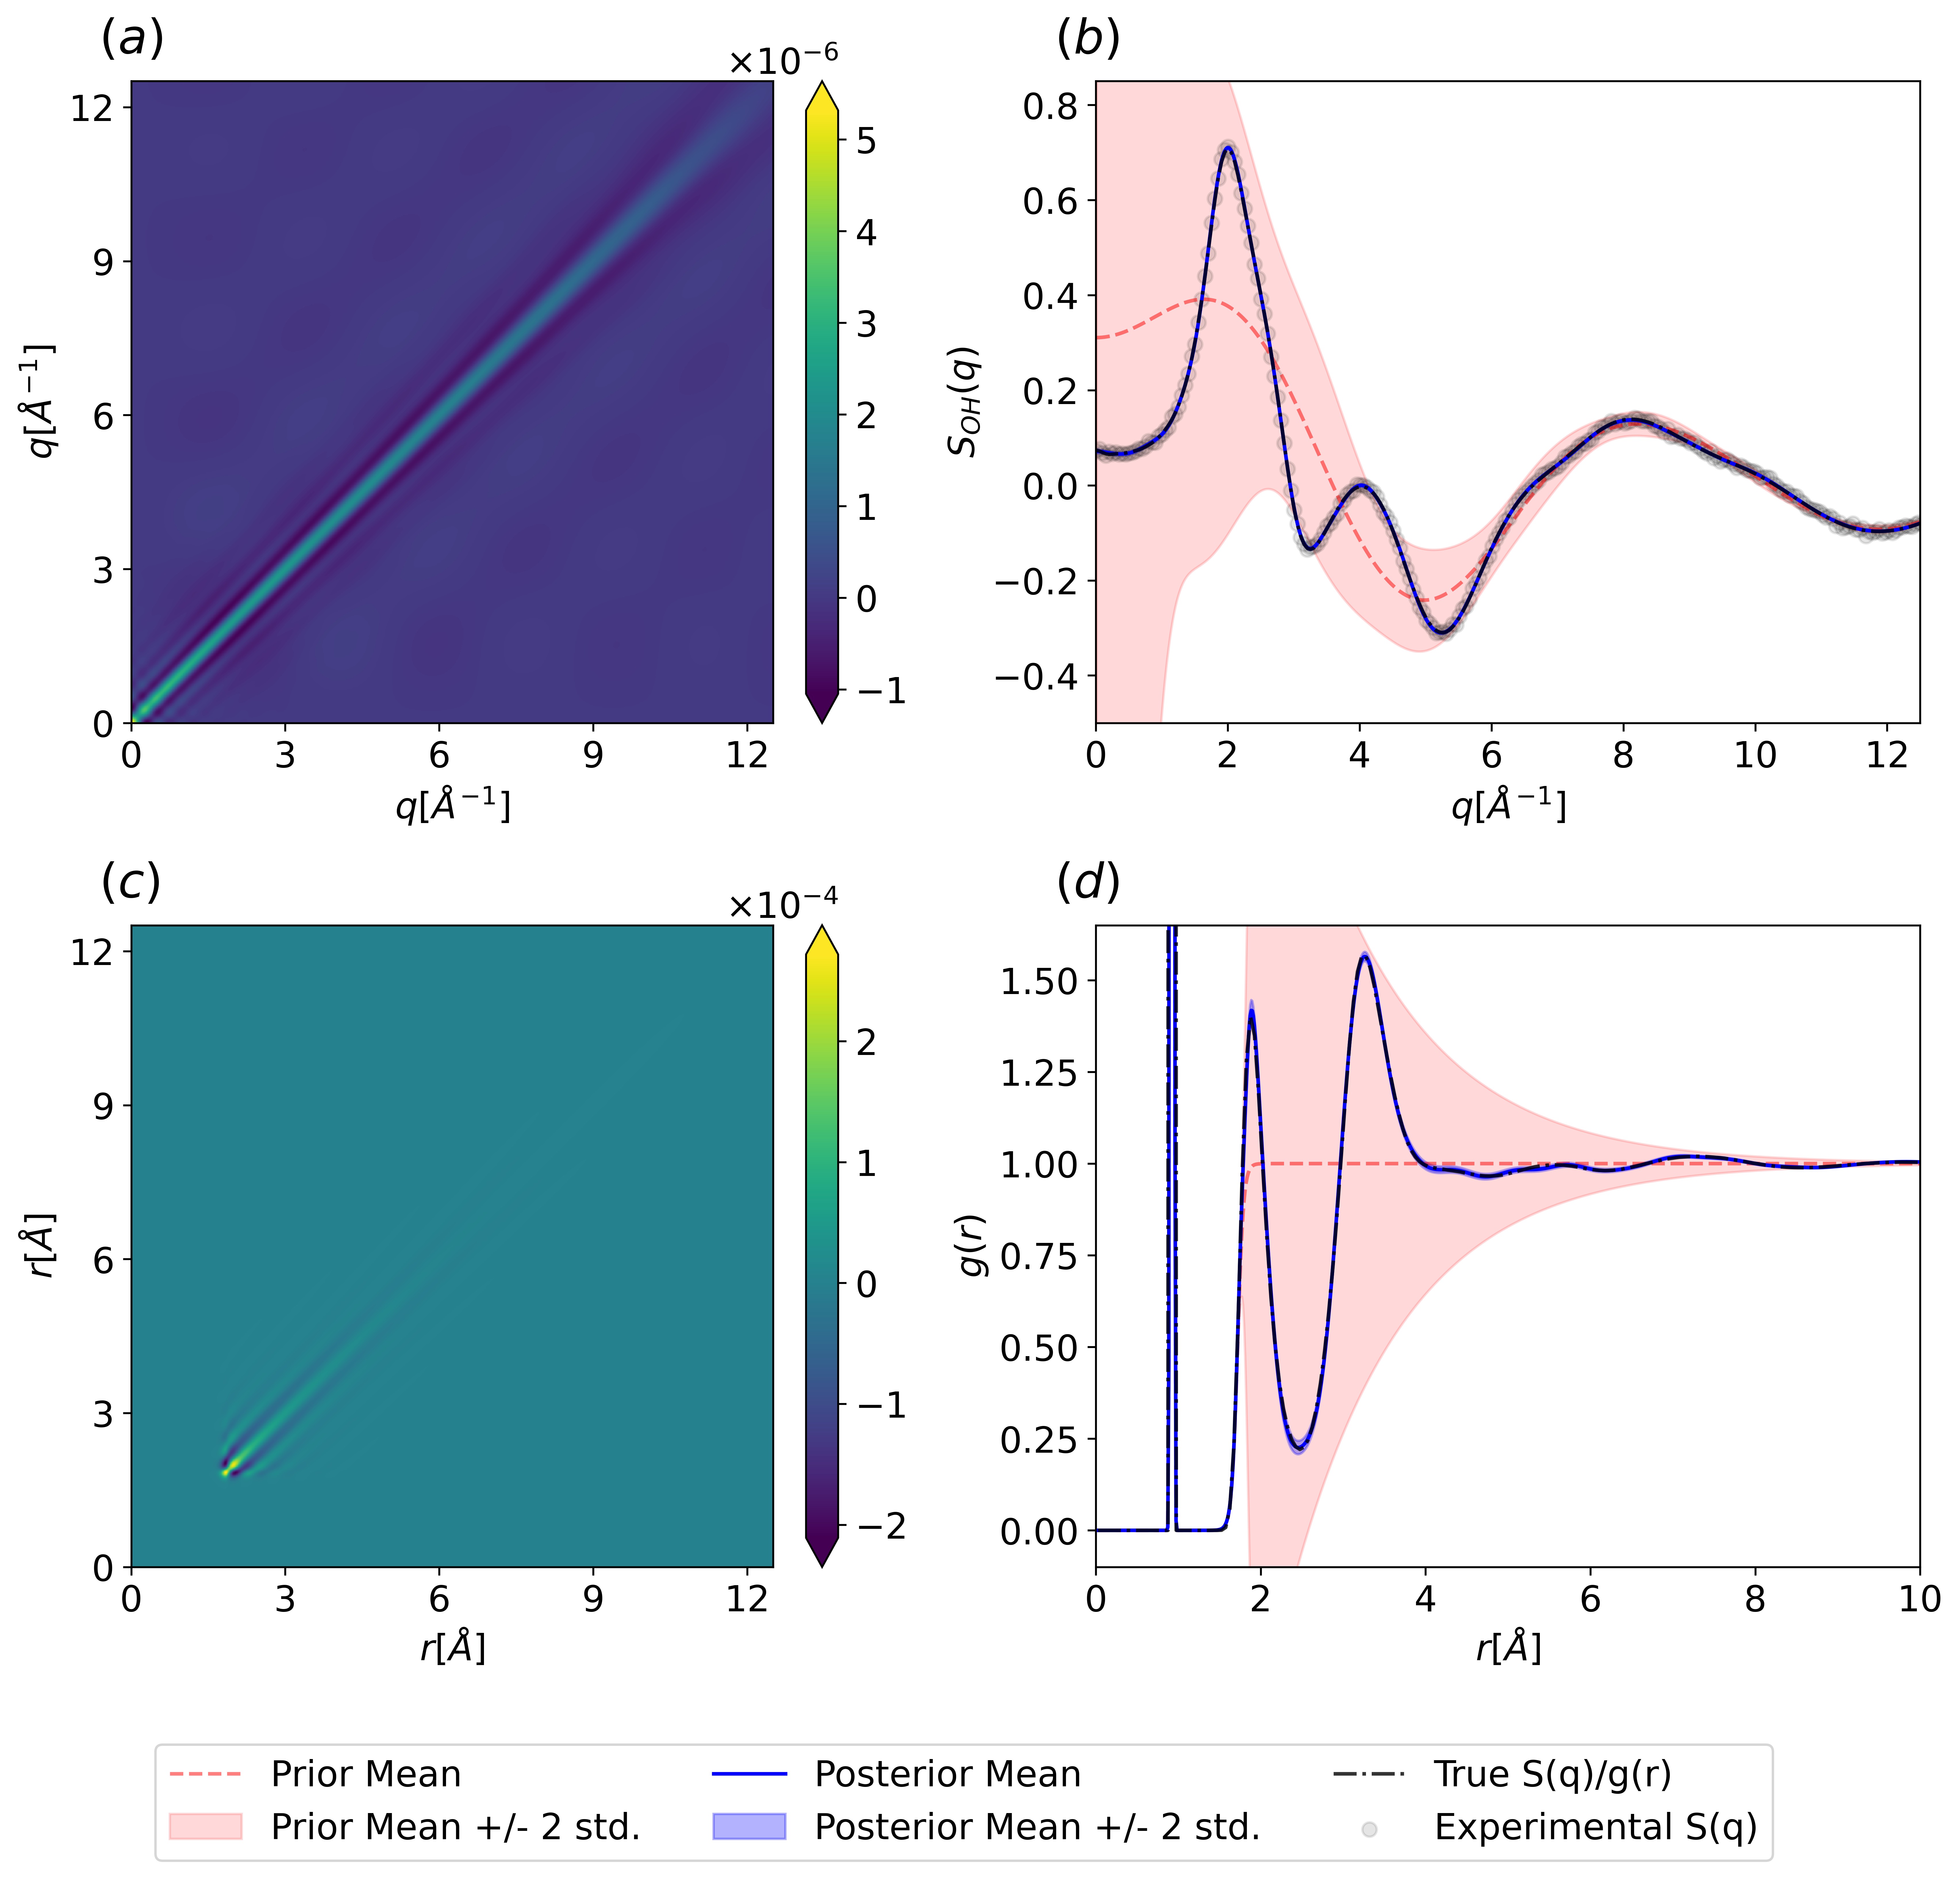

In [17]:
titles = ["$\Sigma_{{Post.}}$", "$\Sigma_{{Post.,RDF}}$",]
xlabels = ["$q [\AA^{-1}]$", "$r [\AA]$"]
ylabels = ["$q [\AA^{-1}]$", "$r [\AA]$"]

fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=600)

bound = 30

for idx, (ax, (kernel, x_dom, y_dom), title, xlabel, ylabel) in enumerate(
        zip(axs[:,0], kernels, titles, xlabels, ylabels)):

    kernel = kernel.clamp(-bound, bound)         
    vmin, vmax = -bound, bound
    extend_opt = 'both'                     

    c = ax.pcolormesh(x_dom.numpy(), y_dom.numpy(),
                      kernel.numpy(), shading='auto',
                      cmap='viridis')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal')

    cb = fig.colorbar(c, ax=ax, fraction=0.046, pad=0.04,
                 extend=extend_opt, extendfrac=0.05)
    
    cb.formatter = ScalarFormatter(useMathText=True)
    cb.formatter.set_scientific(True)
    cb.formatter.set_powerlimits((-2, 2))
    cb.update_ticks()
    
fill_between_alpha = 0.3
prior_fill_between_ratio = 0.5
lettering_size = 20

axs[0,0].set_xticks(np.linspace(0, 12, 5) )
axs[0,0].set_yticks(np.linspace(0, 12, 5) )
axs[1,0].set_xticks(np.linspace(0, 12, 5) )
axs[1,0].set_yticks(np.linspace(0, 12, 5) )
    

axs[0,1].plot(q_infer.T[0], μ_q_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
axs[0,1].fill_between(q_infer.T[0], μ_q_prior.T[0] + 2*torch.diag(Σ_q_prior)**0.5, μ_q_prior.T[0] - 2*torch.diag(Σ_q_prior)**0.5, alpha=prior_fill_between_ratio*fill_between_alpha, label="Prior Mean +/- 2 std.", color='r')
axs[0,1].plot(q_infer.T[0], μ_q_post.T[0], label="Posterior Mean", color='b')
axs[0,1].fill_between(q_infer.T[0], μ_q_post.T[0] + 2*torch.diag(Σ_q_post)**0.5, μ_q_post.T[0] - 2*torch.diag(Σ_q_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
axs[0,1].plot(q_values,partial_sq_OH, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
axs[0,1].scatter(q_train, sq_train, label='Experimental S(q)', alpha=0.1, color='k')
axs[0,1].set_xlim(0, 12.5)
axs[0,1].set_ylim(-0.5,0.85)
axs[0,1].set_xlabel('$q [Å^{-1}]$')
axs[0,1].set_ylabel('$S_{OH}(q)$')

axs[1,1].plot(r_infer.T[0], μ_r_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
axs[1,1].fill_between(r_infer.T[0], μ_r_prior.T[0] + 2*torch.diag(Σ_r_prior)**0.5, μ_r_prior.T[0] - 2*torch.diag(Σ_r_prior)**0.5, alpha=prior_fill_between_ratio*fill_between_alpha, label="Prior Mean +/- 2 std.", color='r')
axs[1,1].plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
axs[1,1].fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
axs[1,1].plot(r,gr_OH, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
# axs[1,1].plot(r_infer.T[0], gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r_infer.T[0], density)+1, label='$\mathcal{H}$ of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
axs[1,1].set_ylim(-0.1, 1.65)
axs[1,1].set_xlim(0, 10)
axs[1,1].set_xlabel('$r [Å]$')
axs[1,1].set_ylabel('$g(r)$')
     
# axins = inset_axes(
#     axs[1, 1],
#     width="35%", height="35%",
#     bbox_to_anchor=(0.62, 0.1, 1, 1),
#     bbox_transform=axs[1,1].transAxes,
#     loc='lower left',
#     borderpad=0
# )

# axins.plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
# axins.fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
# axins.plot(r,gr_OH, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
# axins.plot(r_infer.T[0], gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r_infer.T[0], density)+1, label='$\mathcal{H}$ of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
# axins.set_ylim(0.8, 1.2)
# axins.set_xlim(3, 5.4)
# axins.set_xticks([3.0, 4.0, 5.0])
# axins.set_yticks([0.8, 1.0, 1.15])


# axins.tick_params(labelsize=12)

# mark_inset(axs[1,1], axins, loc1=2, loc2=3, fc="none", ec="0.5",linestyle='dashed',alpha=0.5)


# axins = inset_axes(axs[1,1],
#                    width="35%", height="35%",      
#                    loc='upper right',              
#                    borderpad=1.2)                  

# axins.plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
# axins.fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Posterior Mean +/- 2 std.", color='b')
# axins.plot(r,gr_OH, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
# axins.plot(r_infer.T[0], gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r_infer.T[0], density)+1, label='$\mathcal{H}$ of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
# axins.set_ylim(2.1, 3.1)
# axins.set_xlim(2.6, 3.0)
# axins.set_xticks([2.6, 2.8, 3.0])
# axins.set_yticks([2.2, 2.6, 3.0])


# axins.tick_params(labelsize=12)
# mark_inset(axs[1,1], axins, loc1=2, loc2=3, fc="none", ec="0.5",linestyle='dashed',alpha=0.5)

# Collect unique legend handles and labels
handles1, labels1 = axs[0,1].get_legend_handles_labels()
handles2, labels2 = axs[1,1].get_legend_handles_labels()

# Use dict to ensure uniqueness
handle_label_dict = dict(zip(labels1 + labels2, handles1 + handles2))
labels_combined, handles_combined = zip(*handle_label_dict.items())

# Add figure-level legend below all subplots
fig.legend(
    handles_combined, labels_combined,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=True
)

for i, ax in enumerate(axs.flat):
    label = f"$({string.ascii_lowercase[i]})$"
    ax.text(-0.05, 1.1, label,
            transform=ax.transAxes,
            fontsize=lettering_size, va='top', ha='left')


plt.tight_layout()
plt.savefig("figs/OH_Simulated_post.png", bbox_inches='tight')

(0.8, 1.1)

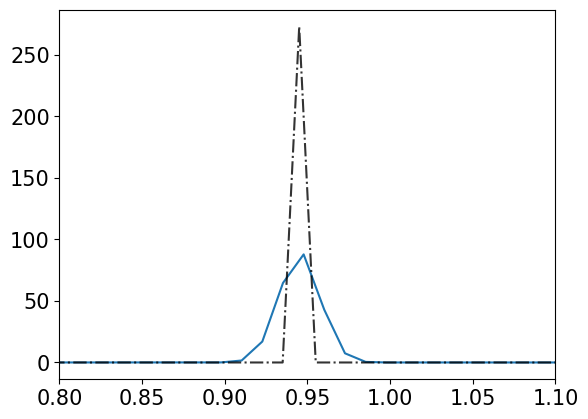

In [9]:
plt.plot(r_infer,μ_r_prior)
plt.plot(r,gr_OH, label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
plt.xlim(0.8,1.1)

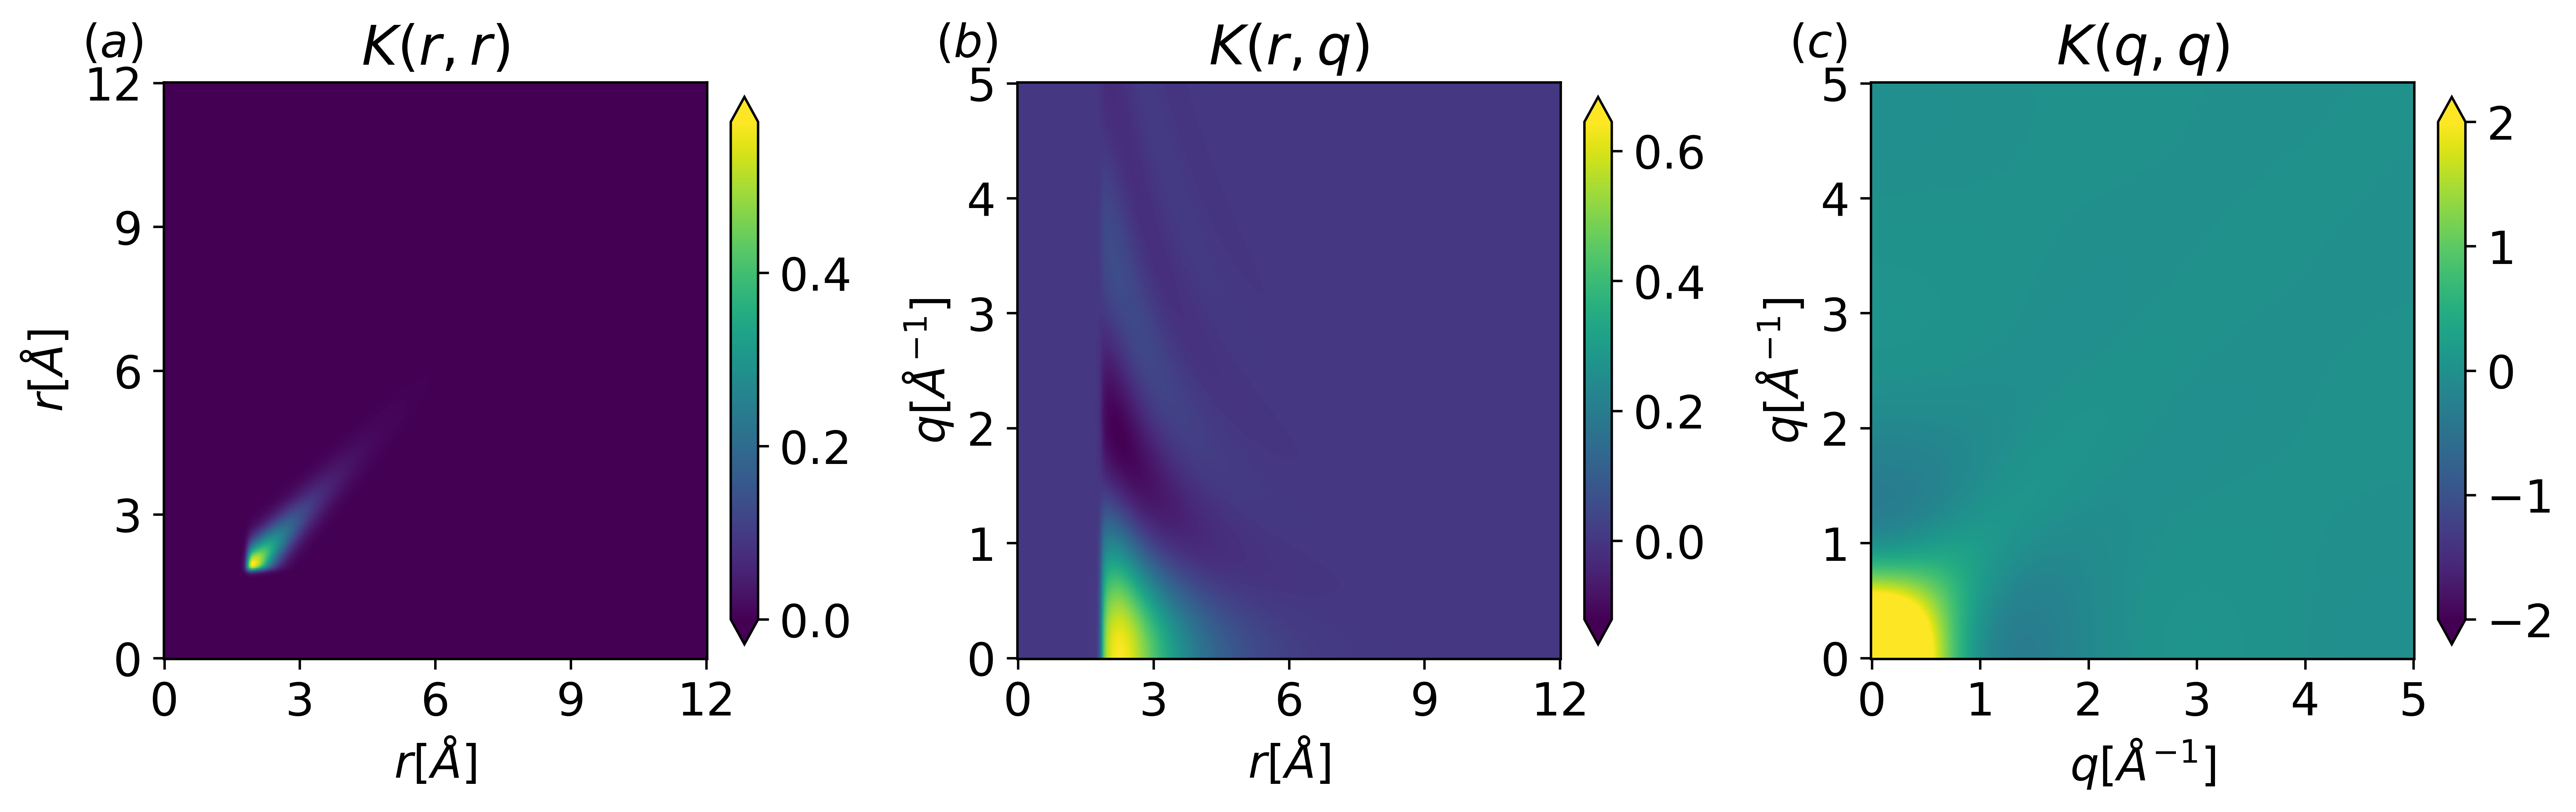

In [14]:
import matplotlib.pyplot as plt
import string

with torch.no_grad():
    r_infer_k_plot = torch.linspace(0.0001, 12, 400, dtype=torch.float64).reshape(-1, 1)
    q_infer_k_plot = torch.linspace(0.0001, 5, 300, dtype=torch.float64).reshape(-1, 1)
    bound = 2

    K1_matrix = gp.K_rr(r_infer_k_plot, r_infer_k_plot, adjust=False).detach()
    K2_matrix = gp.K_rq(r_infer_k_plot, r_grid, q_infer_k_plot, adjust=False).T.detach()
    K3_matrix = gp.K_qq(r_grid, r_grid, q_infer_k_plot, q_infer_k_plot, adjust=False).detach()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=600)

    kernels = [
        (K1_matrix, r_infer_k_plot.T[0], r_infer_k_plot.T[0]),
        (K2_matrix, r_infer_k_plot.T[0], q_infer_k_plot.T[0]),
        (K3_matrix, q_infer_k_plot.T[0], q_infer_k_plot.T[0]),
    ]
    titles = ["$K(r,r)$", "$K(r,q)$", "$K(q,q)$"]
    xlabels = ["$r [\AA]$", "$r [\AA]$", "$q [\AA^{-1}]$"]
    ylabels = ["$r [\AA]$", "$q [\AA^{-1}]$", "$q [\AA^{-1}]$"]

    for idx, (ax, (kernel, x_dom, y_dom), title, xlabel, ylabel) in enumerate(
        zip(axs, kernels, titles, xlabels, ylabels)
    ):
        if idx == 0:
            ticks = np.linspace(0, 12, 5) 
            ax.set_xticks(ticks)
            ax.set_yticks(ticks)
        if idx == 1:
            ax.set_xticks(np.linspace(0, 12, 5) )
            ax.set_yticks(np.linspace(0, 5, 6) )
        if idx == 2:
            kernel = kernel.clamp(-bound, bound)
            vmin, vmax = -bound, bound
            ax.set_yticks(np.linspace(0, 5, 6) )
            ax.set_xticks(np.linspace(0, 5, 6) )
        else:
            vmin, vmax = None, None

        pcm = ax.pcolormesh(x_dom.numpy(), y_dom.numpy(), kernel.numpy(),
                            shading='auto', cmap='viridis',
                            vmin=vmin, vmax=vmax)

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)


        # Colorbar on the right with caps
        cb = fig.colorbar(pcm, ax=ax, orientation='vertical',
                          extend='both', extendfrac=0.05,
                          fraction=0.046, pad=0.04)

    # Add subplot labels
    for i, ax in enumerate(axs):
        label = f"$({string.ascii_lowercase[i]})$"
        ax.text(-0.15, 1.105, label, transform=ax.transAxes,
                va='top', ha='left')

    plt.tight_layout()
    plt.savefig("figs/OH_simulated_kernels.png", bbox_inches='tight')

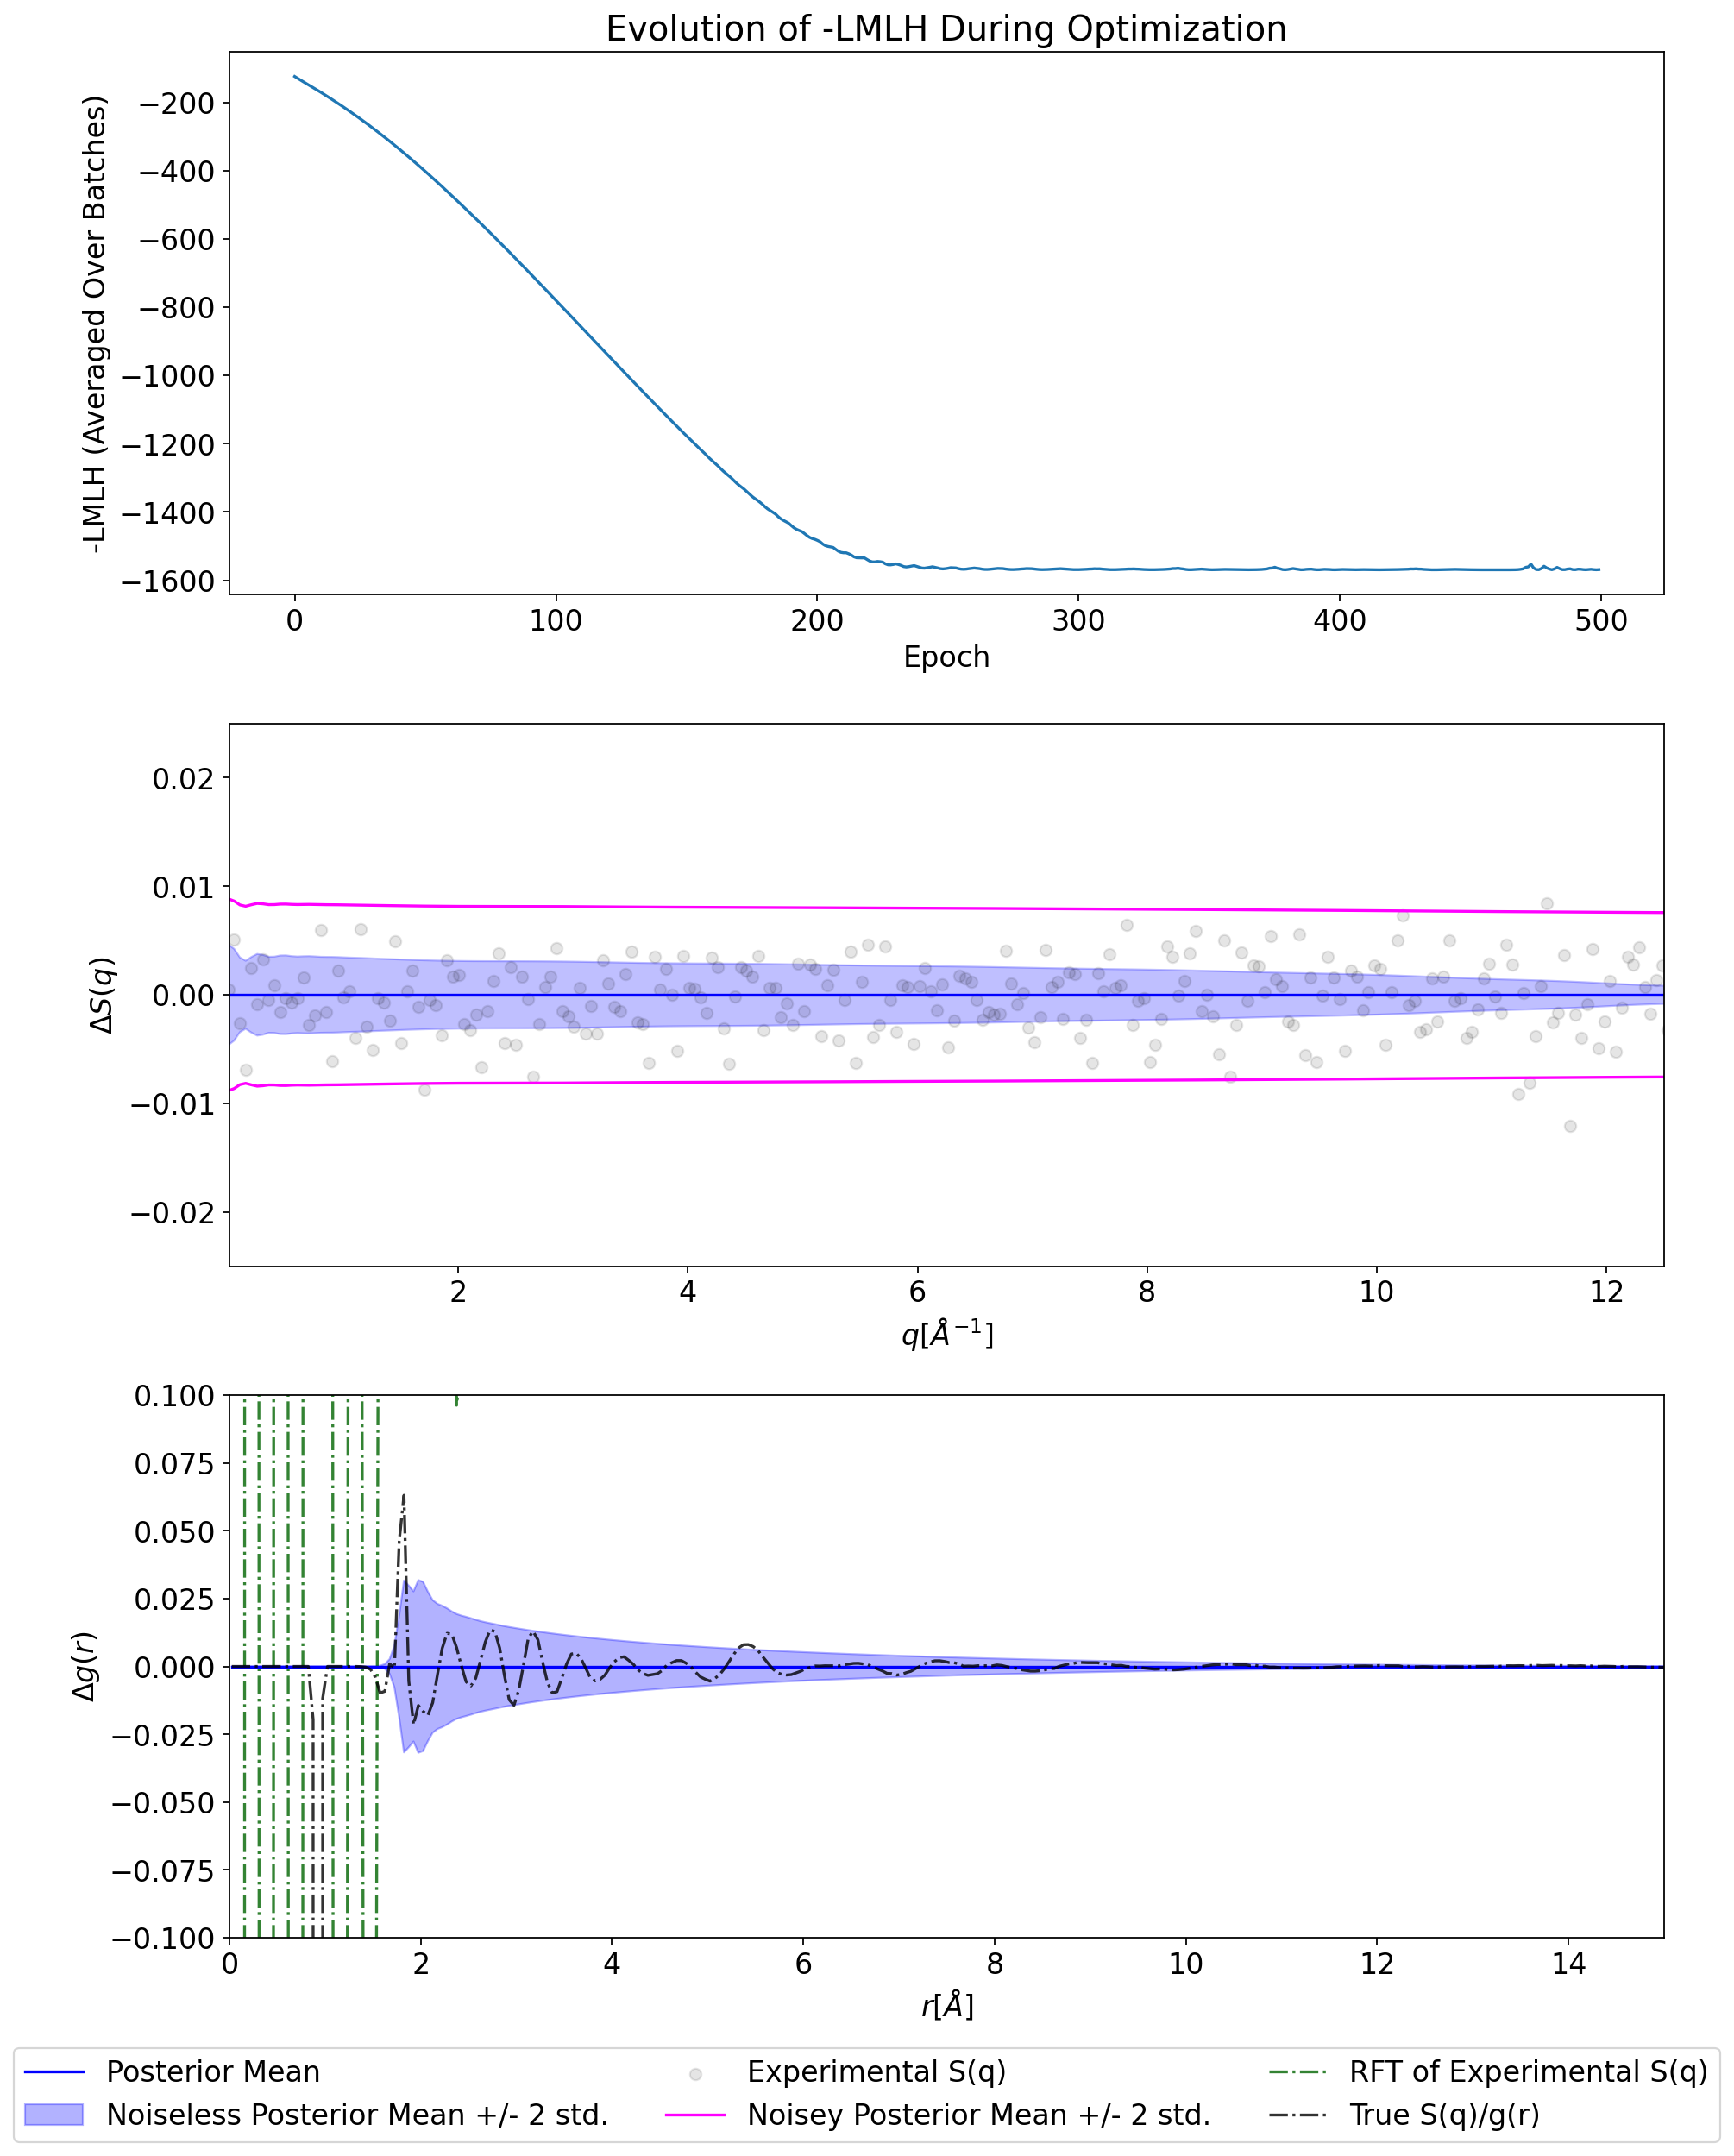

In [15]:
with torch.no_grad():
    fig, axs = plt.subplots(3,1, figsize=(12, 15), dpi=160)
    
    q_infer = q_train
        
    # Calculate Prior Mean and Cov
    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()
    
    Σ_r_prior = gp.K_rr(r.reshape(-1,1),r.reshape(-1,1)).detach()
    μ_r_prior = gp.mean_r(r.reshape(-1,1)).detach()

    # Calculate Posterior Mean and Cov
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()
    
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r.reshape(-1,1), q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()    
        
    axs[1].plot(q_infer.T[0],torch.zeros_like(q_infer.T[0]),label="Posterior Mean",color='b')
    axs[1].fill_between(q_infer.T[0],2*torch.diag(Σ_q_post)**0.5,  -2*torch.diag(Σ_q_post)**0.5,alpha=0.25,label="Noiseless Posterior Mean +/- 2 std.",color='b')
    axs[1].scatter(q_train,sq_train-μ_q_post,label='Experimental S(q)',alpha=0.1,color='k')
    axs[1].plot(q_infer.T[0],2*torch.diag(Σ_q_post + torch.eye(len(q_infer))*(gp.theta[5]**2))**0.5,label="Noisey Posterior Mean +/- 2 std.",color='magenta')
    axs[1].plot(q_infer.T[0],-2*torch.diag(Σ_q_post + torch.eye(len(q_infer))*(gp.theta[5]**2))**0.5,color='magenta')

    axs[1].set_xlim(0.01,12.5)
    axs[1].set_ylim(-0.025,0.025)

    axs[1].set_xlabel('$q [Å^{-1}]$')
    axs[1].set_ylabel('$\Delta S(q)$')
    
    # axs[2].plot(r, μ_r_prior.T[0] - μ_r_post.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    # axs[2].fill_between(r, μ_r_prior.T[0]- μ_r_post.T[0] + 2*torch.diag(Σ_r_prior)**0.5, μ_r_prior.T[0]- μ_r_post.T[0] - 2*torch.diag(Σ_r_prior)**0.5, alpha=prior_fill_between_ratio*fill_between_alpha, label="Prior Mean +/- 2 std.", color='r')
    axs[2].plot(r, gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r, density)+1 - μ_r_post[0], label='RFT of Experimental S(q)', color='darkgreen',alpha=0.8,linestyle='dashdot')
    axs[2].plot(r, μ_r_post.T[0]- μ_r_post.T[0], label="Posterior Mean", color='b')
    axs[2].fill_between(r, μ_r_post.T[0]- μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0]- μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=fill_between_alpha, label="Noiseless Posterior Mean +/- 2 std.", color='b')
    axs[2].plot(r,gr_OH - μ_r_post.T[0] , label='True S(q)/g(r)', alpha=0.8, color='k', linestyle='dashdot')
    
    axs[2].set_ylim(-0.1,0.1)
    axs[2].set_xlim(0,15)
    axs[2].set_xlabel('$r [Å]$')
    axs[2].set_ylabel('$\Delta g(r)$')


    axs[0].plot(torch.tensor(losses), linestyle='-')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('-LMLH (Averaged Over Batches)')
    axs[0].set_title('Evolution of -LMLH During Optimization')
    
    # Collect unique legend handles and labels
    handles1, labels1 = axs[1].get_legend_handles_labels()
    handles2, labels2 = axs[2].get_legend_handles_labels()

    # Use dict to ensure uniqueness
    handle_label_dict = dict(zip(labels1 + labels2, handles1 + handles2))
    labels_combined, handles_combined = zip(*handle_label_dict.items())

    # Add figure-level legend below all subplots
    fig.legend(
        handles_combined, labels_combined,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=3,
        frameon=True
    )

plt.tight_layout()
plt.savefig("figs/OH_simulated_si.png", bbox_inches='tight')